In [147]:
import tensorflow as tf  
import os  
import numpy as np  
import re  
from PIL import Image  
import matplotlib.pyplot as plt

In [149]:
class NodeLookup(object):  
    def __init__(self):  
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'  
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'  
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)  
  
    def load(self, label_lookup_path, uid_lookup_path):  
        #加载分类字符串n ------ 对应分类名称的文件  
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()  
        uid_to_human = {}  
        #一行一行读取数据  
        for line in proto_as_ascii_lines :  
            #去掉换行符  
            line = line.strip('\n')  
            #按照‘\t’分割  
            parsed_items = line.split('\t')  
            #获取分类编号和分类名称  
            uid = parsed_items[0]  
            human_string = parsed_items[1]  
            #保存编号字符串-----与分类名称映射关系  
            uid_to_human[uid] = human_string  
  
  
        #加载分类字符串n ----- 对应分类编号1-1000的文件  
        proto_as_ascii_lines = tf.gfile.GFile(label_lookup_path).readlines()  
        node_id_to_uid = {}  
        for line in proto_as_ascii_lines :  
            if line.startswith('  target_class:'):  
                #获取分类编号1-1000  
                target_class = int(line.split(': ')[1])  
            if line.startswith('  target_class_string:'):  
                #获取编号字符串n****  
                target_class_string = line.split(': ')[1]  
                #保存分类编号1-1000与编号字符串n****的映射关系  
                node_id_to_uid[target_class] = target_class_string[1:-2]  
  
  
        #建立分类编号1-1000对应分类名称的映射关系  
        node_id_to_name = {}  
        for key, val in node_id_to_uid.items():  
            #获取分类名称  
            name = uid_to_human[val]  
            #建立分类编号1-1000到分类名称的映射关系  
            node_id_to_name[key] = name  
        return node_id_to_name  
  
    #传入分类编号1-1000返回分类名称  
    def id_to_string(self, node_id):  
        if node_id not in self.node_lookup:  
            return ''  
        return self.node_lookup[node_id]  

# 创建一个图来存放google训练好的模型  #2 load graph  
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:  
    graph_def = tf.GraphDef()  
    graph_def.ParseFromString(f.read())  
    tf.import_graph_def(graph_def, name='')  
  

In [150]:
conf=0#confidence
top_five=0#top-5
top_one=0
object_name = 'jellyfish'
with tf.Session() as sess:  
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')  
    #遍历目录  
    for root, dirs, files in os.walk('test_images/imageNet_wrap_jellyfish/50*50imageNetwrap_padding0'):  
        for file in files:  
            #载入图片  
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()  
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})#图片格式是jpg格式  
            predictions = np.squeeze(predictions)#把结果转为1维  
  
            #打印图片路径及名称  
            image_path = os.path.join(root,file)  
            #print(image_path)  
            #显示图片  
            img = Image.open(image_path)  
            #plt.imshow(img)  
            #plt.axis('off')  
            #plt.show()  
  
            #排序  
            top_k = predictions.argsort()[-5:][::-1]  
            node_lookup = NodeLookup() 
            if(node_lookup.id_to_string(top_k[0])==object_name):
                top_one+=1
                
             
            for node_id in top_k:  
                #获取分类名称  
                human_string = node_lookup.id_to_string(node_id)  
                #获取该分类的置信度  
                score = predictions[node_id]  
                
                if human_string==object_name:
                    conf+=score
                    top_five+=1#top 5
                #print('%s (score = %.5f)' % (human_string, score))  
            #print()

In [151]:
count=1636.0

In [152]:
print('confidence=',conf/count)

confidence= 0.0488811827567221


In [153]:
print('top-5=',top_five/count)

top-5= 0.2438875305623472


In [154]:
print('top-1=',top_one/count)

top-1= 0.08679706601466992


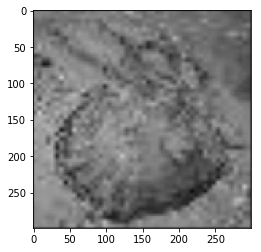

In [155]:
plt.imshow(img)